Conectando ao Google Drive para obter as imagens

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importação das bibliotecas necessárias

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model, load_img, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array

from tqdm import tqdm_notebook

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2
from keras.applications import VGG16

### Verifica se a GPU está disponível para uso pelo TensorFlow

In [3]:
print("GPU Available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU Not Detected")

GPU Available


Carrega os caminhos para as imagens e separa os arquivos que serão usados para treino e para teste

In [4]:
from os import listdir

image_path = '/content/drive/MyDrive/TCC/images_cut/'
labels_path = '/content/drive/MyDrive/TCC/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

train_imgs= [image_path + i for i in train_files]
train_masks= [ labels_path + i for i in train_files]

val_imgs = [image_path + i for i in val_files]
val_masks = [labels_path + i for i in val_files]

In [5]:
print("Training images:", len(train_imgs))
print("Validation images:", len(val_imgs))

Training images: 80
Validation images: 20


In [6]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

### Definição do gerador de dados

Será necessário para evitar que todas as imagens sejam carregadas em memória.
Fonte: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [7]:
class DataGenerator(Sequence):

    def __init__(self,
                 images,
                 labels,
                 batch_size=16,
                 dim=(224,224,3),
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.images[i], target_size=self.dim, grayscale=False)
            img = img_to_array(img)/255
            batch_imgs.append(img)
            label = load_img(self.labels[i], target_size=self.dim, grayscale=False)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels, dtype = np.float32)

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

def display_sample(data_tuple, img_shape):
    X,y = data_tuple
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(X[0])
    plt.subplot(122)
    plt.imshow(np.reshape(y[0], img_shape))

In [9]:
batch_size = 16
train_generator = DataGenerator(train_imgs, train_masks, batch_size=batch_size, dim=(224,224,3), shuffle=True)
train_generator.__getitem__(1)
train_steps = train_generator.__len__()

<ipython-input-7-19e28b6764a6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-7-19e28b6764a6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


<ipython-input-7-19e28b6764a6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-7-19e28b6764a6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


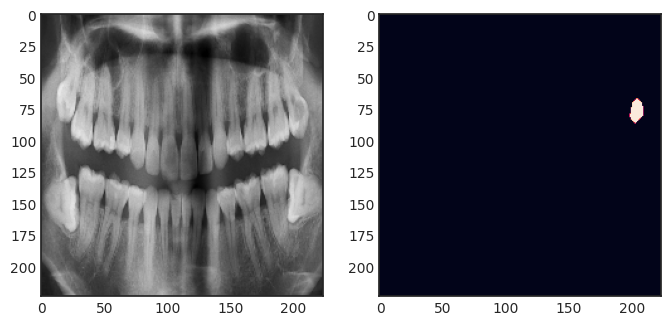

In [10]:
display_sample(train_generator.__getitem__(1), (224,224))

In [11]:
val_generator = DataGenerator(val_imgs, val_masks, batch_size=batch_size, dim=(224,224,3), shuffle=True)
val_steps = val_generator.__len__()
val_images = val_generator.images

<ipython-input-7-19e28b6764a6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-7-19e28b6764a6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


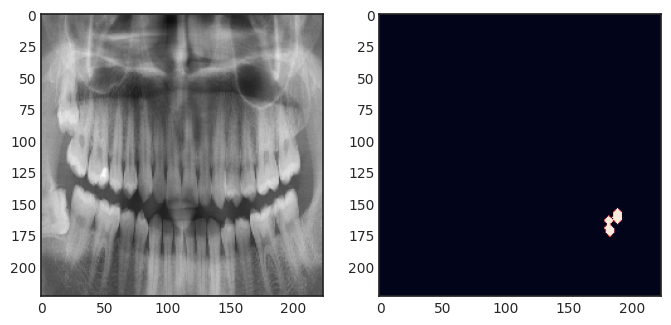

In [12]:
display_sample(val_generator.__getitem__(1), (224, 224))

# Modelo de U-Net com backbone constrúido com VGG16 pré-treinada

In [13]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [14]:
def conv_block(inputs, filterCount, kernel_size=3):
    x = Conv2D(filterCount, kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filterCount, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, filter_count):

    # x = Conv2DTranspose(
    #     filter_count,
    #     2,
    #     strides = (2, 2),
    #     activation = 'relu',
    #     padding = 'same',
    #     kernel_initializer = 'he_normal')(inputs)

    x = Conv2D(
        filter_count,
        2,
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(inputs))

    # x = Conv2D(filter_count, strides=2, padding='same')(inputs)
    x = Conv2D(
        filter_count,
        3,
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(x)

    x = Conv2D(
        filter_count,
        3,
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(x)

    x = BatchNormalization()(x)

    x = concatenate([x, skip])

    return x

In [15]:
def UnetVgg(input_shape):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor = inputs)

    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    center = vgg16.get_layer("block5_conv3").output

    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

(None, 224, 224, 3)
58889256/58889256 [==============================] - 3s 0us/step
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
   

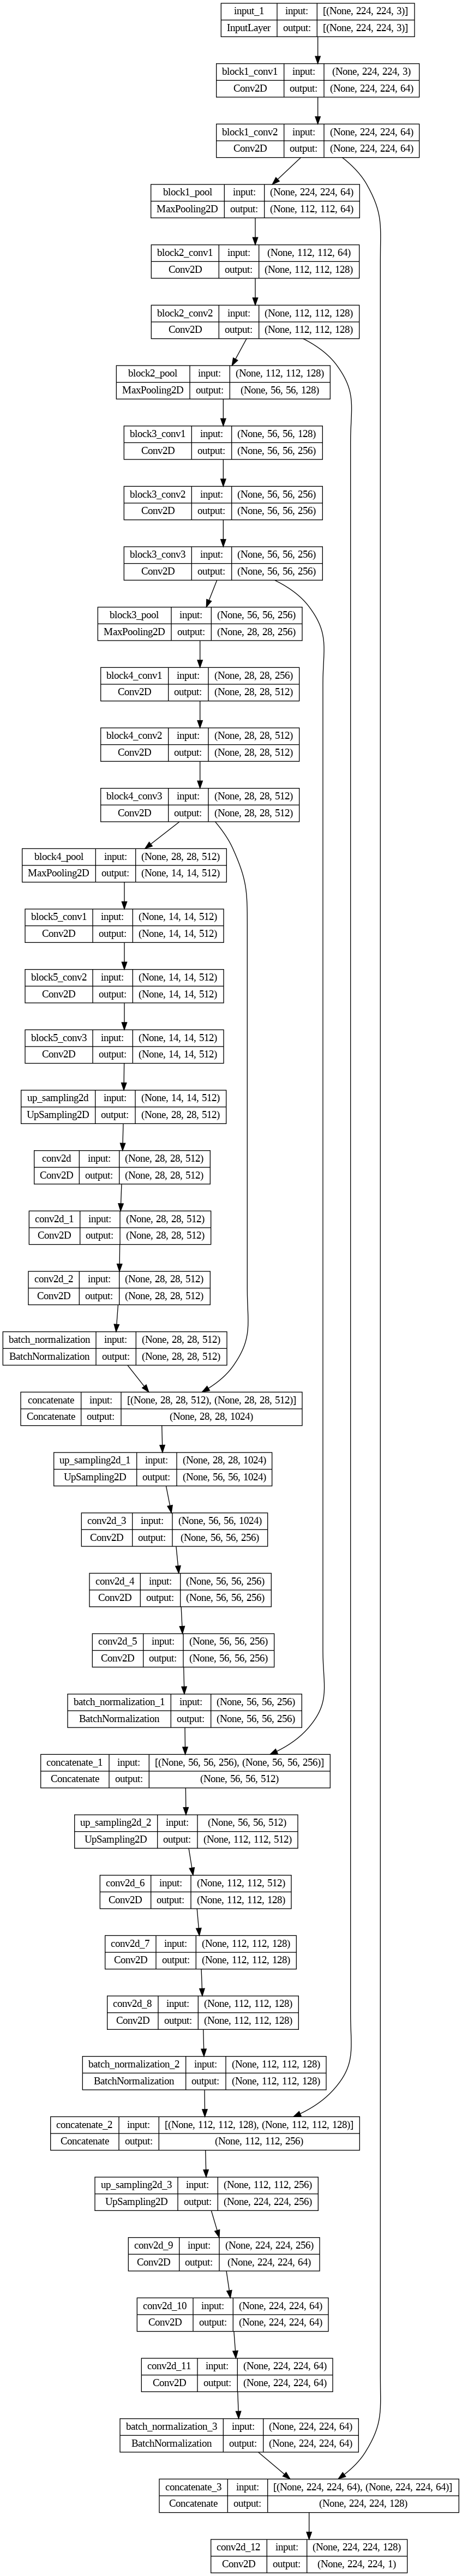

In [16]:
model = UnetVgg(input_shape=(224,224, 3))
model.summary()
plot_model(model, show_shapes=True)

### Métricas de perda customizadas

O índice de Jaccard é útil para situações onde as classes são desbalanceadas.

In [17]:
from keras.losses import binary_crossentropy

def jaccard_distance_loss(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Jaccard_index
    smooth = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    print("y_true_f", y_true_f)
    print("Score", 1. - score)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    print("y_true, y_pred", y_true, y_pred)
    return binary_crossentropy(y_true, y_pred) + jaccard_distance_loss(y_true, y_pred)

In [18]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top.weights.h5', monitor='dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
# es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc]
model.metrics_names

[]

In [19]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [20]:
model_history = model.fit(train_generator, steps_per_epoch=train_steps,epochs=60,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

<ipython-input-7-19e28b6764a6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-7-19e28b6764a6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/100
y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_12/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_12/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
5/5 [==============================] - ETA: 0s - loss: 0.3541 - dice_coef: 0.0051 - accuracy: 0.8852y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_12/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)

Epoch 1: dice_coef improved from -inf to 0.00513, saving model to top.weights.h5
5/5 [==============================] - 87s 17s/step - loss: 0.3541 - dice_coef: 0.0051 - accuracy: 0.8852 - val_loss: 18.4618 - val_dice_coef: 0.0075 - val_accuracy: 0.0215
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0342 - dice_coef: 0.0000e+00 - accur

In [23]:
model_history.history.keys()

dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])

In [28]:
loss = model_history.history["loss"]

accuracy = model_history.history["accuracy"]

val_loss = model_history.history["val_loss"]

val_accuracy = model_history.history["val_accuracy"]

val_dice_coef = model_history.history["val_dice_coef"]

In [29]:
max(val_dice_coef)

0.17440681159496307

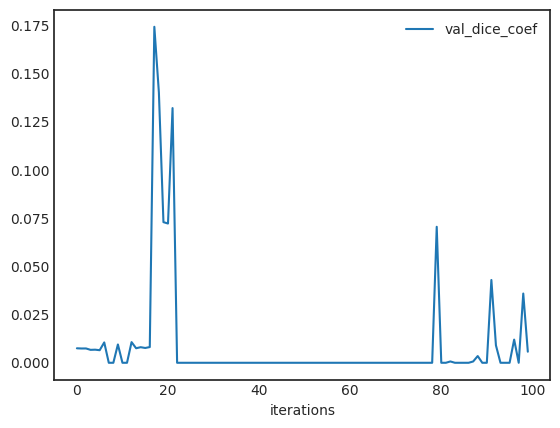

In [30]:
plt.plot(val_dice_coef,label = "val_dice_coef")
plt.xlabel("iterations")
plt.legend()

In [31]:
max(loss)

0.35409682989120483

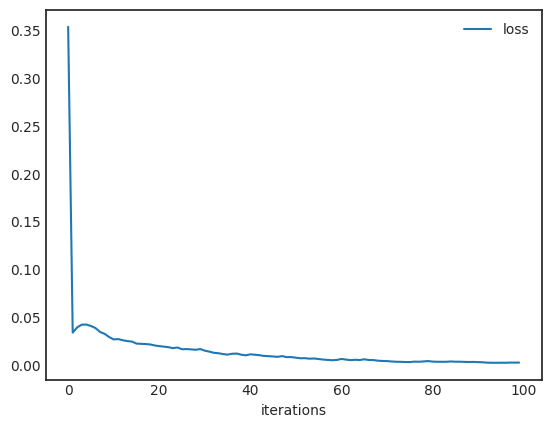

In [32]:
plt.plot(loss,label = "loss")
plt.xlabel("iterations")
plt.legend()

In [27]:
max(accuracy)

0.999210774898529

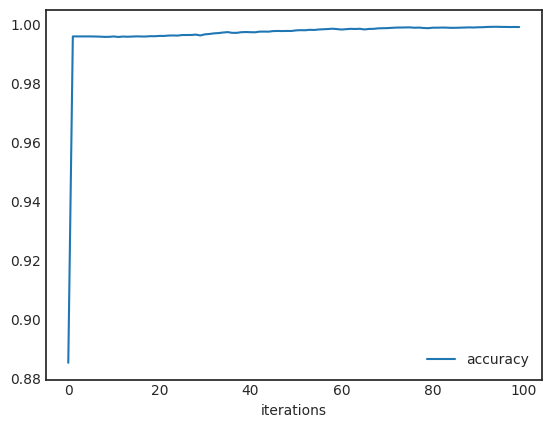

In [33]:
plt.plot(accuracy,label = "accuracy")
plt.xlabel("iterations")
plt.legend()

In [34]:
max(val_loss)

39.2320442199707

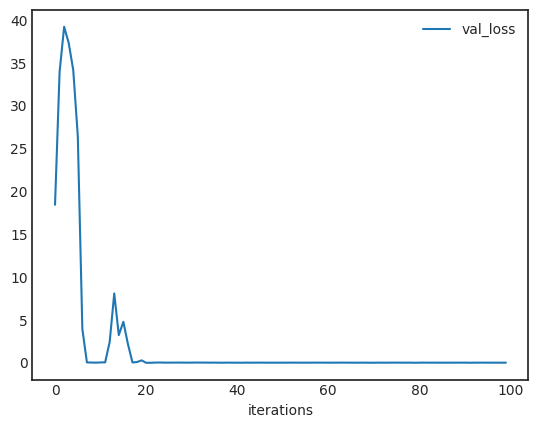

In [35]:
plt.plot(val_loss,label = "val_loss")
plt.xlabel("iterations")
plt.legend()

In [36]:
max(val_accuracy)

0.9969569444656372

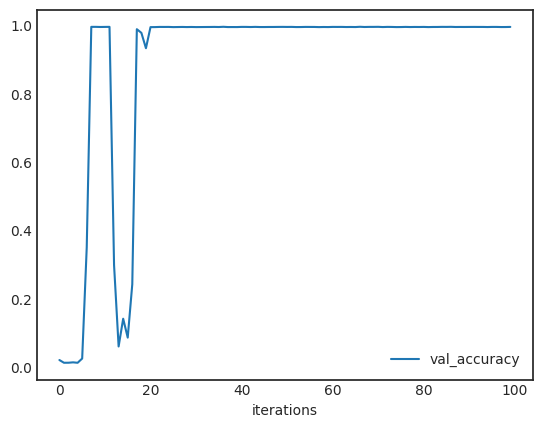

In [37]:
plt.plot(val_accuracy,label = "val_accuracy")
plt.xlabel("iterations")
plt.legend()

In [38]:
model.save_weights('top.weights.h5')

In [39]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = np.reshape(mask,(224,224,1))
    return mask

350.png


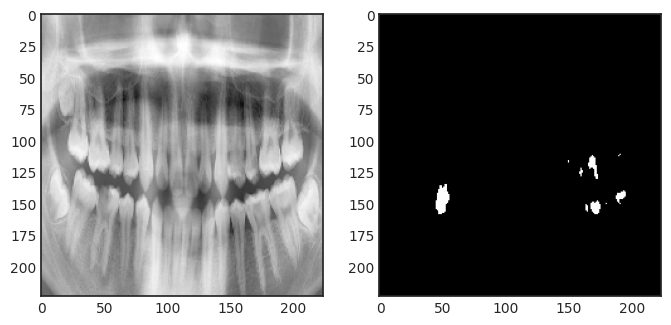

In [44]:
test_image_path = train_files[10]

image = '/content/drive/MyDrive/TCC/images_cut/' + test_image_path
img = img_to_array(load_img(image, target_size=(224,224,3)))/255

mask = '/content/drive/MyDrive/TCC/labels_cut/' + test_image_path
mask_img = img_to_array(load_img(mask, target_size=(224,224,3)))

print(test_image_path)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask_img/255.)

1/1 [==============================] - 0s 30ms/step


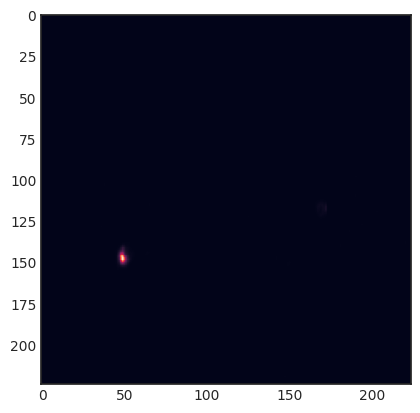

In [45]:
mask = make_prediction(model,image,(224,224))
plt.imshow(mask)